## 프로젝트 : 네이버 영화리뷰 감성 분석 도전하기

### 라이브러리 버전을 확인해 봅니다

In [1]:
import pandas
import konlpy
import gensim

### 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
> 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

#### 데이터셋 내 문장 길이 분포 확인

In [6]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('평균 : ', np.mean(num_tokens))
print('최대 : ', np.max(num_tokens))
print('표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

평균 :  15.96940191154864
최대 :  116
표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함


/tmp/ipykernel_90/2953519588.py:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')  # y축을 로그 스케일로 설정


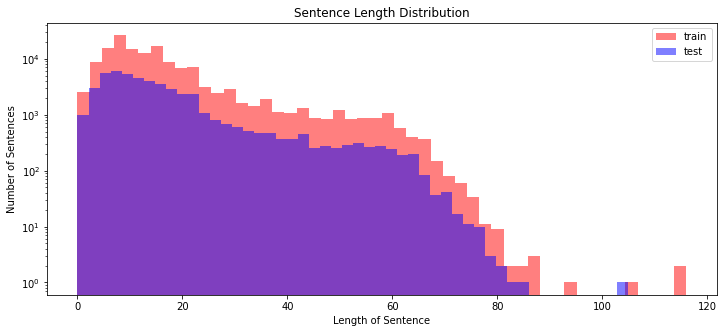

In [7]:
import matplotlib.pyplot as plt

# 문장의 길이 확인
train_sentence_len = [len(sentence) for sentence in X_train]
test_sentence_len = [len(sentence) for sentence in X_test]

# 문장 길이 분포 시각화
plt.figure(figsize=(12, 5))
plt.hist(train_sentence_len, bins=50, alpha=0.5, color='r', label='train')
plt.hist(test_sentence_len, bins=50, alpha=0.5, color='b', label='test')
plt.yscale('log', nonposy='clip')  # y축을 로그 스케일로 설정
plt.title('Sentence Length Distribution')
plt.xlabel('Length of Sentence')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

#### 최대 문장 길이 지정

In [8]:
max_len = int(max_tokens)  # 적절한 최대 문장 길이로 지정

#### 패딩 추가

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

### 4) 모델 구성 및 Validation Set 구성

#### Embedding Layer + LSTM

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model1 = Sequential()
model1.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(LSTM(8)) 
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

#### Embedding Layer + Conv1D

In [12]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

model2 = Sequential()
model2.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(Conv1D(16, 7, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Conv1D(16, 7, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### Embedding Layer + GlobalMaxPooling1D

In [13]:
from tensorflow.keras.layers import Bidirectional

model3 = Sequential()
model3.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(8, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [14]:
# 각 모델에 대해 훈련 시작
history1 = model1.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2, verbose=1)
history2 = model2.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2, verbose=1)
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=512, validation_split=0.2, verbose=1)

Epoch 1/5
229/229 [==============================] - 33s 8ms/step - loss: 0.5093 - accuracy: 0.7668 - val_loss: 0.3794 - val_accuracy: 0.8424
Epoch 2/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3471 - accuracy: 0.8551 - val_loss: 0.3532 - val_accuracy: 0.8493
Epoch 3/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3217 - accuracy: 0.8657 - val_loss: 0.3533 - val_accuracy: 0.8489
Epoch 4/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3104 - accuracy: 0.8715 - val_loss: 0.3543 - val_accuracy: 0.8468
Epoch 5/5
229/229 [==============================] - 1s 6ms/step - loss: 0.3019 - accuracy: 0.8759 - val_loss: 0.3555 - val_accuracy: 0.8482
Epoch 1/5
229/229 [==============================] - 19s 7ms/step - loss: 0.4909 - accuracy: 0.7537 - val_loss: 0.3619 - val_accuracy: 0.8437
Epoch 2/5
229/229 [==============================] - 1s 5ms/step - loss: 0.3280 - accuracy: 0.8601 - val_loss: 0.3416 - val_accuracy: 0.8518
Epoch 3/5
2

In [15]:
#학습이 끝난 모델을 테스트셋으로 평가
results = []
results.append(model1.evaluate(X_test, y_test, verbose=2))
results.append(model2.evaluate(X_test, y_test, verbose=2))
results.append(model3.evaluate(X_test, y_test, verbose=2))

print(results)

1537/1537 - 3s - loss: 0.3616 - accuracy: 0.8463
1537/1537 - 3s - loss: 0.3643 - accuracy: 0.8493
1537/1537 - 2s - loss: 0.3663 - accuracy: 0.8405
[[0.3616263270378113, 0.8463087677955627], [0.3642646372318268, 0.8493195176124573], [0.36632871627807617, 0.8404906988143921]]


### 6) Loss, Accuracy 그래프 시각화


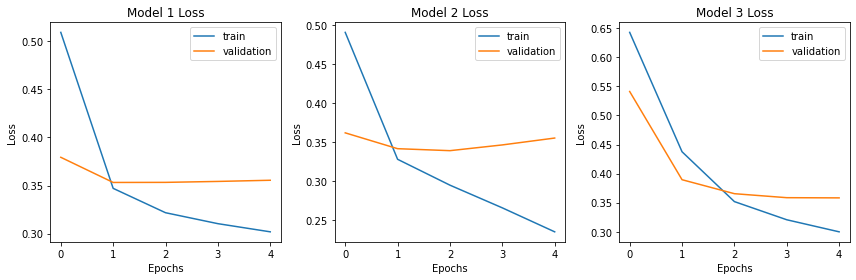

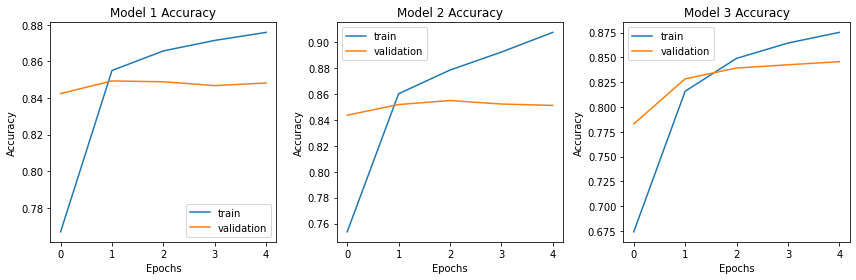

In [36]:
# Loss 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='validation')
plt.title('Model 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.title('Model 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.title('Model 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Accuracy 그래프 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='validation')
plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.title('Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.title('Model 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Loss 그래프 해석
- train(훈련) 데이터의 Loss는 훈련할수록 줄어든다.
- validation(검증) 데이터의 Loss는 초기에는 감소되다가 일정 시점 이후, 증가한다. 

### Accuracy 그래프 해석
- train(훈련) 데이터의 정확도는 훈련할수록 올라간다.
- validation(검증) 데이터의 정확도는 초기에는 증가하다가 일정 시점 이후 크게 변동하지 않거나, 줄어든다.

### 결과 해석
- 과적합 문제를 해결해야할 것 같다.

### 7) 학습된 Embedding 레이어 분석

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
import os
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)


In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        # Make sure the dimensions match
        if len(word_vectors.wv[index_to_word[i]]) == word_vector_dim:
            embedding_matrix[i] = word_vectors[index_to_word[i]]


In [31]:
from tensorflow.keras.layers import Dropout

#LSTM 모델 구성
model = Sequential()
'''
# fist try
model.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True))   
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))
'''

print(embedding_matrix)
model.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Dropout(0.5))  
# model.add(Bidirectional(LSTM(256)))
# model.add(Dropout(0.5))  
model.add(Dense(1, activation='sigmoid'))

model.summary()

[[0.37372192 0.85973059 0.53938397 ... 0.04796443 0.41978681 0.84559682]
 [0.67536717 0.14143996 0.12355445 ... 0.90500626 0.67561536 0.09245569]
 [0.29383692 0.96812113 0.48064728 ... 0.88242391 0.39360905 0.24289831]
 ...
 [0.05005071 0.6473723  0.16661396 ... 0.3084252  0.27671325 0.43075342]
 [0.3543833  0.94301176 0.10174474 ... 0.14744917 0.09337876 0.67580543]
 [0.70611126 0.86655444 0.38116971 ... 0.07987568 0.9252517  0.75631364]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 41, 256)           336896    
_________________________________________________________________
dense_6 (Dense)              (None, 41, 1)             257       
Total params: 2,337,153
Trainable params: 2,337,153
Non-trainable params

In [32]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
2128/2128 [==============================] - 22s 9ms/step - loss: 0.4236 - accuracy: 0.7953 - val_loss: 0.3290 - val_accuracy: 0.8552
Epoch 2/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.3137 - accuracy: 0.8666 - val_loss: 0.3164 - val_accuracy: 0.8618
Epoch 3/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.2831 - accuracy: 0.8815 - val_loss: 0.3131 - val_accuracy: 0.8641
Epoch 4/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.2580 - accuracy: 0.8934 - val_loss: 0.3180 - val_accuracy: 0.8674
Epoch 5/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.2353 - accuracy: 0.9041 - val_loss: 0.3331 - val_accuracy: 0.8651
Epoch 6/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.2144 - accuracy: 0.9137 - val_loss: 0.3417 - val_accuracy: 0.8619
Epoch 7/10
2128/2128 [==============================] - 19s 9ms/step - loss: 0.1935 - accuracy: 0.9235 - val_loss: 0.3575 - val_ac

In [33]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


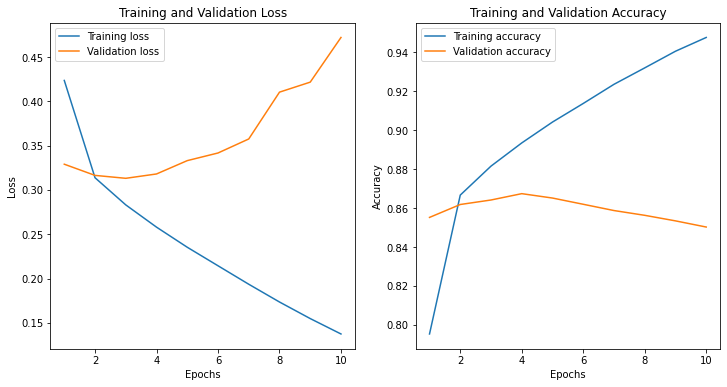

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [35]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4669 - accuracy: 0.8507
[0.4669162631034851, 0.8507440686225891]


## Hyper Prameter test
1st - LSTM(8), Epochs = 20, batch_size = 64  -> result: 0.825  
2nd - 오버피팅인 것 같아서 Dropout 추가. LSTM(64) - Dropout(0.5) - LSTM(32) - Dropout(0.5) - Dense, 나머진 동일 -> 0.840  
3rd - LSTM(64) - Dropout(0.5) - LSTM(64) - Dropout(0.5) - Dense, 나머진 동일 -> 0.8425  
4th - LSTM(128) - Dropout(0.5) - LSTM(64) - Dropout(0.5) - Dense, 나머진 동일 -> 0.8442  
5th - LSTM(256) - Dropout(0.5) - LSTM(64) - Dropout(0.5) - Dense, 나머진 동일 -> 0.8416  
6th - LSTM(256) - Dropout(0.5) - LSTM(128) - Dropout(0.5) - Dense, 나머진 동일 -> 0.8432  
7th - LSTM(256) - Dense, 나머진 동일 - 0.8427  
8th - LSTM(256) - Dropout(0.5) - LSTM(256) - Dropout(0.5) - Dense, 나머진 동일 -> 0.8437  
9th - LSTM(256) - Dropout(0.5) - LSTM(256) - Dropout(0.5) - Dense, size= 64 나머진 동일 -> 0.8437  
10th - LSTM(256) - Dropout(0.5) - LSTM(256) - Dropout(0.5) - Dense, size= 128 나머진 동일 -> 0.8437  
11th - LSTM(128) - Dense, size= 65, epochs = 15, 나머진 동일 -> 0.8444  
12th - LSTM(128) - Dense, size= 64, epochs = 12, 나머진 동일 -> 0.8493  
13th - LSTM(128) - Dense, size= 64, epochs = 10, 나머진 동일 -> 0.8441  
14th - LSTM(128) - Dense, size= 64, epochs = 10, 나머진 동일 -> 0.8502  
15th - LSTM(128) - Dense, size= 64, epochs = 10, 나머진 동일 -> 0.8507


## 회고..
힘들었습니다. 총 14번을 수행한 끝에 운이 좋아(?) 루브릭의 기준(0.85)을 겨우 넘긴 것 같습니다.  
처음 모델을 돌렸을 때, Loss 그래프와 Acc 그래프에서 오버피팅된 것 같아 Dropout 규제화 기법을 사용했습니다.  
그 결과, 정확도는 눈에 띄게 향상 되었으나, 84%까지밖에 오르지 않았습니다.  
그래서, 처음부터 다시 돌아가자라는 마인드로 초기 설정에서 LSTM의 노드 수는 늘리고, 에폭 값을 낮췄더니 정확도가 향상되어 차근 차근 조금씩 낮추다보니 85%라는 마의 장벽을 뚫을 수 있었습니다.    
이번 프로젝트를 통해 하이퍼 파라미터 튜닝의 중요성을 깨달았고, 하이퍼파라미터 튜닝을 어떤 방식으로 해야 좋은 값을 얻을지 생각해보는 시간을 가질 수 있었습니다.  
NLLP 어려워요..

